# Preparing the data for predictive analysis
- Checking for missing values
- Handling outliers
- Feature selection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV, RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix



from keys import conn_str

In [2]:
df = pd.read_sql_table('eda', conn_str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13493 entries, 0 to 13492
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Created                  13493 non-null  datetime64[ns]
 1   index                    13493 non-null  int64         
 2   Number                   13493 non-null  object        
 3   Date                     13493 non-null  object        
 4   Gross                    13493 non-null  float64       
 5   InvoiceID                13493 non-null  object        
 6   PointsEarned             13493 non-null  float64       
 7   Variants.NettPrice       13493 non-null  float64       
 8   Variants.DiscountAmount  13493 non-null  float64       
 9   Variants.Discount        13493 non-null  float64       
 10  Variants.PriceOriginal   13493 non-null  float64       
 11  Variants.Price           13493 non-null  float64       
 12  Variants.Cost            13493 n

In [3]:
df.drop(['Count' ,'Payments.Date', 'PointsEarned', 'Date', 'Variants.Code', 'Payments.Note', 'Payments.Code',
         'Variants.PriceOriginal', 'Gross'], axis=1, inplace=True)

In [4]:
df.isnull().sum()

Created                      0
index                        0
Number                       0
InvoiceID                    0
Variants.NettPrice           0
Variants.DiscountAmount      0
Variants.Discount            0
Variants.Price               0
Variants.Cost                0
Variants.Quantity            0
Variants.Name                0
Payments.Method              0
Payments.Amount              0
year                         0
month                        0
day                          0
dayOfWeek                    0
weekOfMonth                  0
hour                         0
minute                       0
LastPurchaseDate             0
Recency                      0
Frequency                    0
LastPurYear                  0
LastPurMonth                 0
LastPurDay                   0
weekDayOfLastPur             0
yearWeekOfLastPur            0
LastPurHour                  0
LastPurMinute                0
ItemTimeDiff                 1
ProductTimeDiff            260
GrossMar

In [5]:
df = df.rename(columns=
               {"Payments.Amount": "PaidAmount",
                "Payments.Method": "PaymentMethod",
                "Variants.Cost": "UnitCost",
                "Variants.Discount": "ProductDiscount",
                "Variants.DiscountAmount": "ProductDiscountAmount",
                "Variants.Name": "product",
                "Variants.NettPrice": "TotalPrice",
                "Variants.Price": "UnitPrice",
                "Variants.Quantity": "Quantity",
                "day": "Day",
                "hour": "Hour",
                "minute": "Minute",
                "month": "Month",
                "year": "Year",
                "Number": "number",
                "Created": "created",
                "InvoiceID": "invoiceid",
                "dayOfWeek": "DayOfWeek",
                "weekOfMonth": "WeekOfMonth",
                "LastPurchaseDate": "lastPurchaseDate",
                "weekDayOfLastPur": "WeekDayOfLastPur",
                "yearWeekOfLastPur": "WeekOfLastPur"
                })
df.head()

,created,index,number,invoiceid,TotalPrice,ProductDiscountAmount,ProductDiscount,UnitPrice,UnitCost,Quantity,...,WeekOfLastPur,LastPurHour,LastPurMinute,ItemTimeDiff,ProductTimeDiff,GrossMargin,ProfitLoss,MarginPerc,MarginDeviation,DeviationType
0,2020-02-07 22:51:30.473,0,20.02.002,a4f938d7-a234-49f9-9588-ea6dc1b547b2,200.0,0.0,0.0,200.0,0.0,1.0,...,22,18,36,1.0,1303.0,200.0,Profit,1.000000,0.000000,Negative
1,2020-02-07 22:52:50.140,1,20.02.003,89681b1f-21ab-4f0a-8780-3971de3f82b0,400.0,0.0,0.0,200.0,120.0,2.0,...,45,21,13,1.0,2898.0,80.0,Profit,0.666667,0.333333,Negative
2,2020-02-07 22:53:26.450,2,20.02.004,af594745-e964-4051-ae17-93b23b746743,100.0,0.0,0.0,100.0,75.0,1.0,...,38,20,37,12.0,72.0,25.0,Profit,0.333333,0.666667,Negative
3,2020-02-07 23:05:02.100,3,20.02.005,a76090aa-9470-4ef5-8e38-59568d23bdae,300.0,0.0,0.0,300.0,183.0,1.0,...,46,20,26,0.0,2886.0,117.0,Profit,0.639344,0.360656,Negative
4,2020-02-07 23:05:02.100,3,20.02.005,a76090aa-9470-4ef5-8e38-59568d23bdae,80.0,0.0,0.0,80.0,0.0,1.0,...,8,18,14,16.0,2725.0,80.0,Profit,1.000000,0.000000,Negative


In [6]:
df = df.reindex(sorted(df.columns), axis=1)
df

,Day,DayOfWeek,DeviationType,Frequency,GrossMargin,Hour,ItemTimeDiff,LastPurDay,LastPurHour,LastPurMinute,...,WeekDayOfLastPur,WeekOfLastPur,WeekOfMonth,Year,created,index,invoiceid,lastPurchaseDate,number,product
0,7,4,Negative,87,200.0,22,1.0,30,18,36,...,5,22,6,2020,2020-02-07 22:51:30.473,0,a4f938d7-a234-49f9-9588-ea6dc1b547b2,2020-05-30 18:36:43.857,20.02.002,Ladies Dress 200bob 2001
1,7,4,Negative,14,80.0,22,1.0,2,21,13,...,0,45,6,2020,2020-02-07 22:52:50.140,1,89681b1f-21ab-4f0a-8780-3971de3f82b0,2020-11-02 21:13:17.210,20.02.003,Men Trousers
2,7,4,Negative,130,25.0,22,12.0,20,20,37,...,6,38,6,2020,2020-02-07 22:53:26.450,2,af594745-e964-4051-ae17-93b23b746743,2020-09-20 20:37:31.790,20.02.004,Men tshirts
3,7,4,Negative,56,117.0,23,0.0,10,20,26,...,1,46,6,2020,2020-02-07 23:05:02.100,3,a76090aa-9470-4ef5-8e38-59568d23bdae,2020-11-10 20:26:25.740,20.02.005,Lady Hand bag
4,7,4,Negative,11,80.0,23,16.0,17,18,14,...,0,8,6,2020,2020-02-07 23:05:02.100,3,a76090aa-9470-4ef5-8e38-59568d23bdae,2020-02-17 18:14:30.623,20.02.005,Children Jackets 80bob 3003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13488,25,0,Positive,136,33.0,22,0.0,25,22,22,...,0,4,4,2021,2021-01-25 22:22:41.243,2750,746f97a4-947b-497b-830f-dd1d1c05394b,2021-01-25 22:22:41.243,21.01.513,Cotton Tops
13489,25,0,Negative,94,-24.0,22,11.0,26,0,4,...,1,4,4,2021,2021-01-25 22:22:41.243,2750,746f97a4-947b-497b-830f-dd1d1c05394b,2021-01-26 00:04:36.673,21.01.513,Velvet 4
13490,25,0,Negative,43,-50.0,22,91.0,26,0,4,...,1,4,4,2021,2021-01-25 22:33:50.673,2751,7a2899db-2d87-46bc-a9c4-565d08df0d0d,2021-01-26 00:04:36.673,21.01.514,pallazo pants 5
13491,26,1,Negative,94,-24.0,0,0.0,26,0,4,...,1,4,4,2021,2021-01-26 00:04:36.673,2752,5f82a83d-5547-4d20-9b5f-54f1d3b77493,2021-01-26 00:04:36.673,21.01.515,Velvet 4


In [7]:
df.drop(['created', 'index', 'invoiceid', 'lastPurchaseDate', 'number'], inplace=True, axis=1)

### Categorical Variables

In [8]:
categorical = [var for var in df.columns if df[var].dtype=="O" and var not in ['number']]
print("{} categorical variables".format(len(categorical)))

4 categorical variables


### Numerical Variables

In [9]:
numerical = [var for var in df.columns if df[var].dtype!="O"]
print("{} numerical variables".format(len(numerical)))

28 numerical variables


### Temporal Variables

In [10]:
time_vars = [var for var in numerical if "Year" in var or "Month" in var
                 or "Week" in var or "Day" in var or "Hour" in var or "Minute" in var]
df[time_vars].head()

,Day,DayOfWeek,Hour,LastPurDay,LastPurHour,LastPurMinute,LastPurMonth,LastPurYear,Minute,Month,WeekDayOfLastPur,WeekOfLastPur,WeekOfMonth,Year
0,7,4,22,30,18,36,5,2020,51,2,5,22,6,2020
1,7,4,22,2,21,13,11,2020,52,2,0,45,6,2020
2,7,4,22,20,20,37,9,2020,53,2,6,38,6,2020
3,7,4,23,10,20,26,11,2020,5,2,1,46,6,2020
4,7,4,23,17,18,14,2,2020,5,2,0,8,6,2020


### Finding discrete numerical values

In [11]:
discrete = []

for var in numerical:
    if len(df[var].unique())<20 and var not in time_vars:
        print(var, 'values: ', df[var].unique())
        discrete.append(var)

print('{} discrete variables'.format(len(discrete)))

ProductDiscount values:  [ 0. 20. 15. 10. 25.]
ProductDiscountAmount values:  [ 0. 50. 30. 60. 20.  5. 40.]
2 discrete variables


### Finding continuous numerical values

In [12]:
numerical = [var for var in numerical if var not in discrete and var not in time_vars and var not in ['Minute']]
print(numerical)

['Frequency', 'GrossMargin', 'ItemTimeDiff', 'MarginDeviation', 'MarginPerc', 'PaidAmount', 'ProductTimeDiff', 'Quantity', 'Recency', 'TotalPrice', 'UnitCost', 'UnitPrice']


## Checking for missing values

In [13]:
vars_with_na = [var for var in df.columns if df[var].isnull().sum()>0]
print("Variables with missing information: ", len(vars_with_na))

Variables with missing information:  2


In [14]:
#visualisation of missing values per variable
for var in df.columns:
    if df[var].isnull().sum():
        print(var, df[var].isnull().mean())

ItemTimeDiff 7.411250277921885e-05
ProductTimeDiff 0.0192692507225969


In [15]:
'''Filling nan values with 0 because they represent a time when the item/product did not have a preceding interval'''

df['ItemTimeDiff'].fillna(value=0.0, inplace=True)
df.ItemTimeDiff.tail()

13488     0.0
13489    11.0
13490    91.0
13491     0.0
13492     0.0
Name: ItemTimeDiff, dtype: float64

In [16]:
'''Filling nan values with 0 because they represent a time when the item/product did not have a preceding interval'''

df['ProductTimeDiff'].fillna(value=0.0, inplace=True)
df.ProductTimeDiff.tail()


13488      0.0
13489    102.0
13490     91.0
13491      0.0
13492      0.0
Name: ProductTimeDiff, dtype: float64

In [17]:
# this code inspects the variables types with missing values
for var in df.columns:
    if df[var].isnull().mean()>0.80:
        print(var, df[var].unique())

## Outlier Detection

In [18]:
numerical

['Frequency',
 'GrossMargin',
 'ItemTimeDiff',
 'MarginDeviation',
 'MarginPerc',
 'PaidAmount',
 'ProductTimeDiff',
 'Quantity',
 'Recency',
 'TotalPrice',
 'UnitCost',
 'UnitPrice']

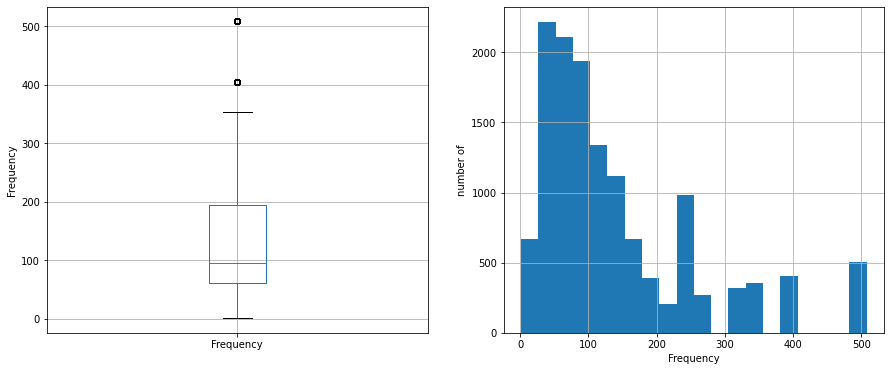

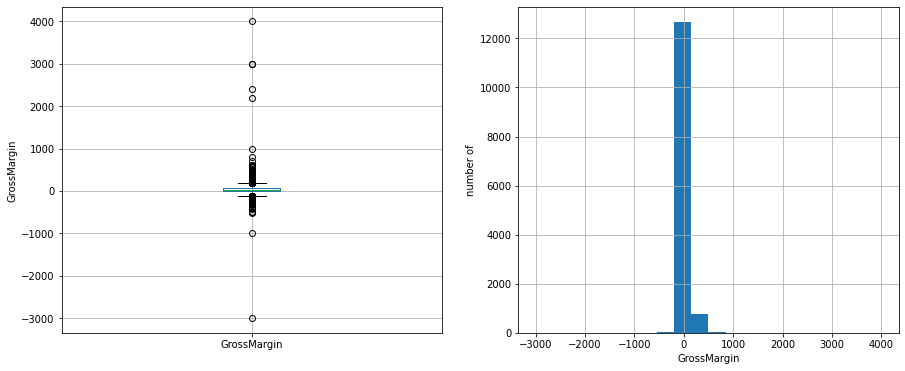

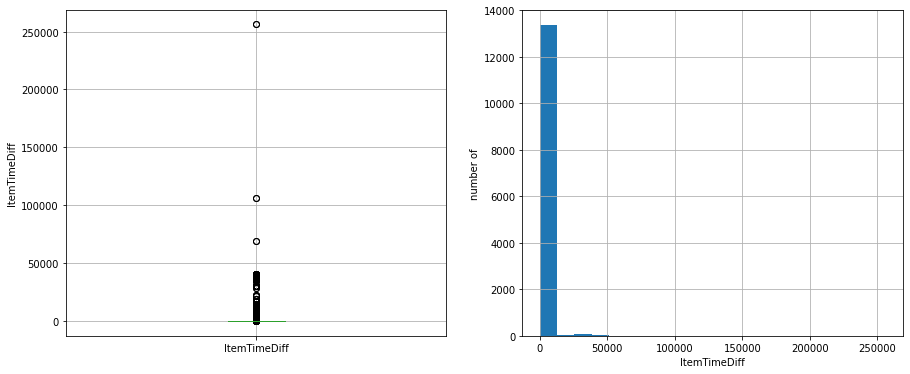

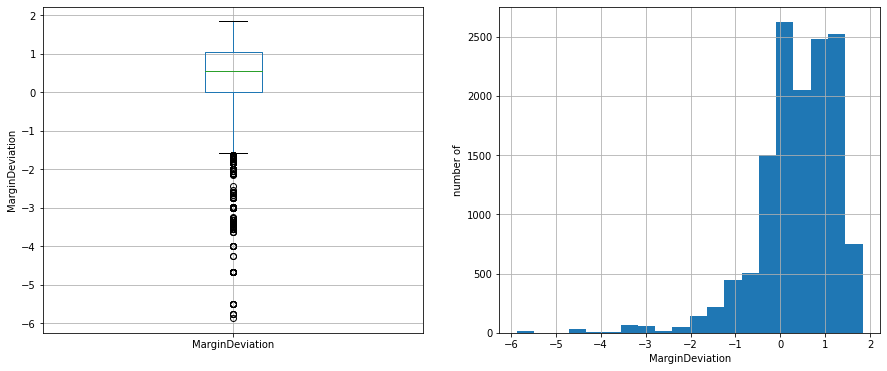

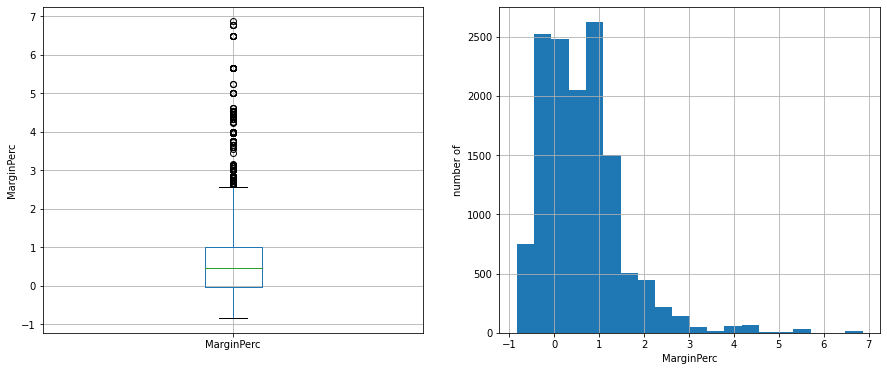

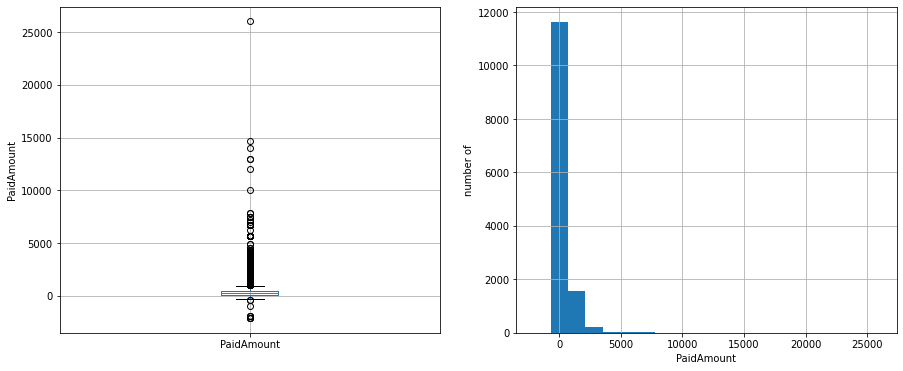

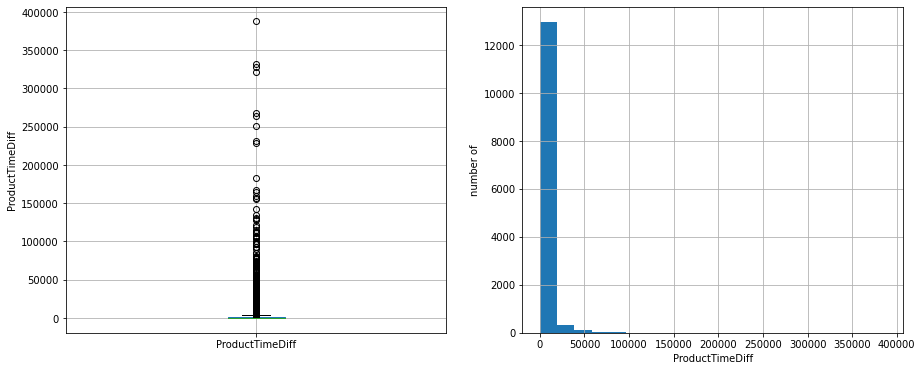

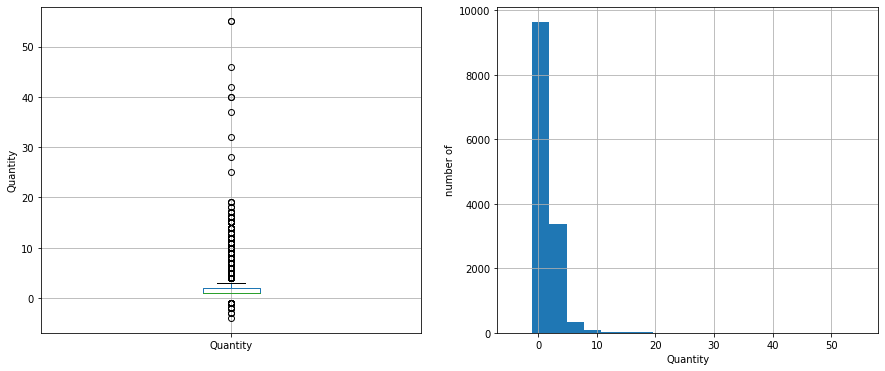

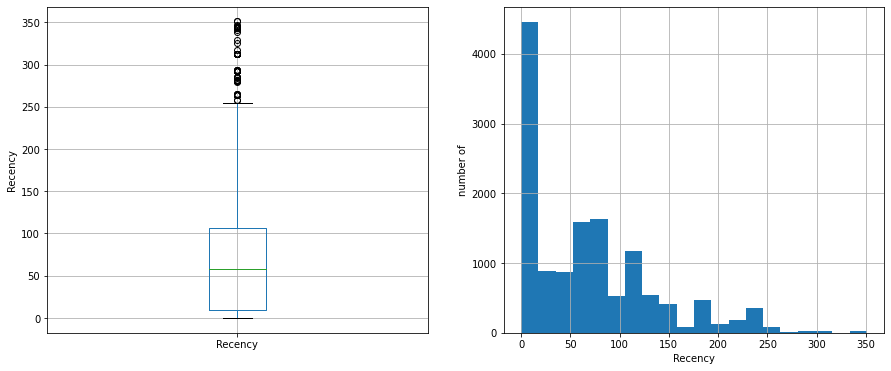

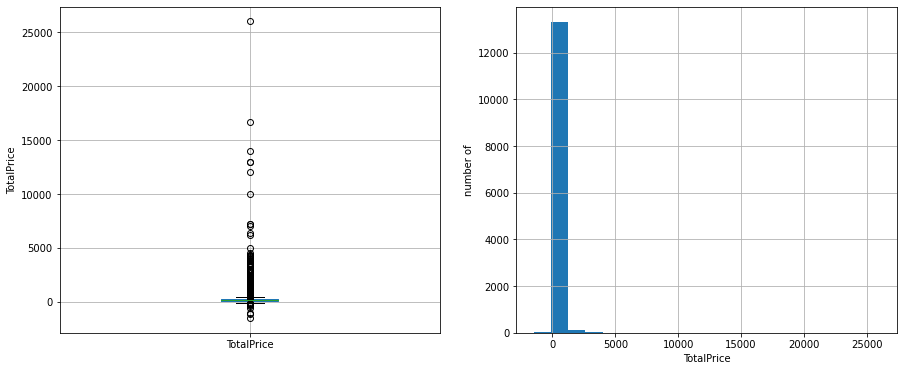

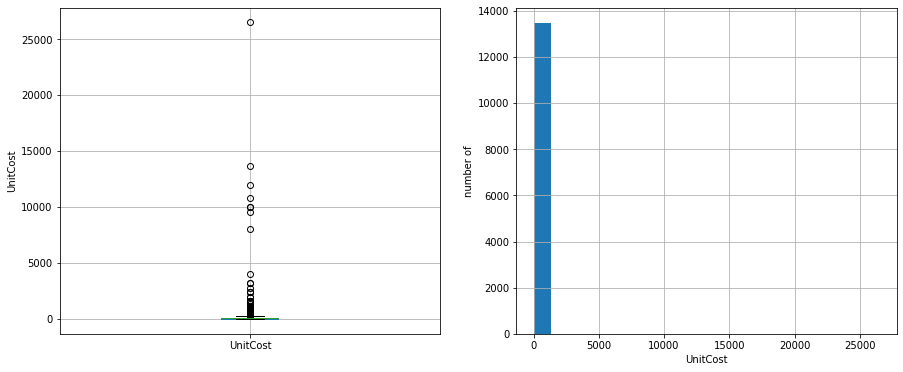

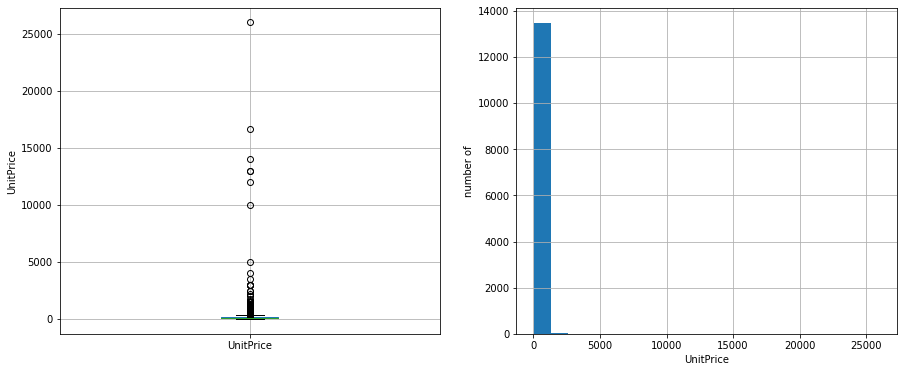

In [19]:
for var in numerical:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = df.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)

    plt.subplot(1, 2, 2)
    fig = df[var].hist(bins=20)
    fig.set_ylabel('number of')
    fig.set_xlabel(var)

    plt.show()

## Cardinality check

Text(0, 0.5, 'Number of different categories')

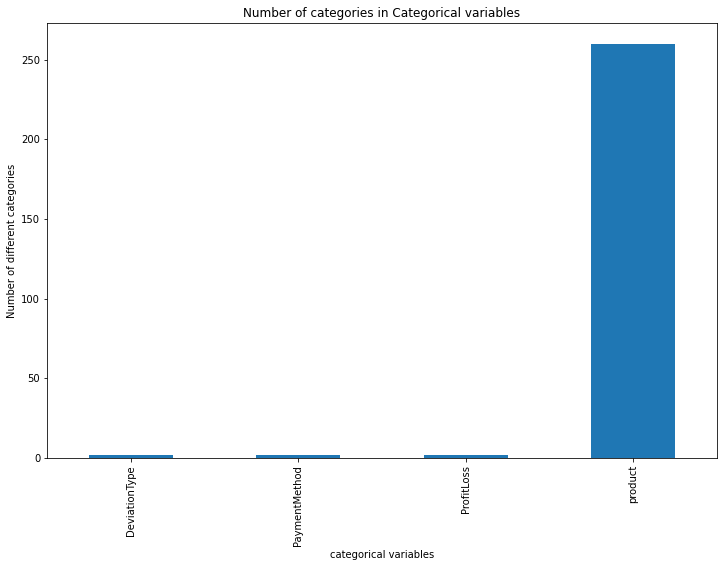

In [20]:
no_labels_ls = []
for var in categorical:
    no_labels_ls.append(df[var].nunique())

tmp = pd.Series(no_labels_ls)
tmp.index = pd.Series(categorical)
tmp.plot.bar(figsize=(12,8))
plt.title('Number of categories in Categorical variables')
plt.xlabel('categorical variables')
plt.ylabel('Number of different categories')

In [21]:
X = df.drop("UnitPrice", axis=1)
y = df.UnitPrice

In [22]:
X.drop(columns=['Year', 'LastPurYear'], axis=1, inplace=True)

# Thought bubble

In [23]:
categorical_feature_columns = list(set(df.columns) - set(df._get_numeric_data().columns))
categorical_feature_columns

['DeviationType', 'product', 'ProfitLoss', 'PaymentMethod']

In [24]:

numerical_feature_columns = list(df._get_numeric_data().columns)
numerical_feature_columns

['Day',
 'DayOfWeek',
 'Frequency',
 'GrossMargin',
 'Hour',
 'ItemTimeDiff',
 'LastPurDay',
 'LastPurHour',
 'LastPurMinute',
 'LastPurMonth',
 'LastPurYear',
 'MarginDeviation',
 'MarginPerc',
 'Minute',
 'Month',
 'PaidAmount',
 'ProductDiscount',
 'ProductDiscountAmount',
 'ProductTimeDiff',
 'Quantity',
 'Recency',
 'TotalPrice',
 'UnitCost',
 'UnitPrice',
 'WeekDayOfLastPur',
 'WeekOfLastPur',
 'WeekOfMonth',
 'Year']

In [25]:
target = 'UnitPrice'

<AxesSubplot:>

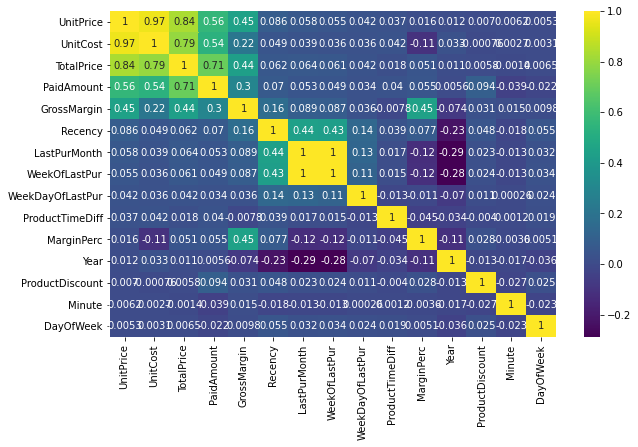

In [26]:
k = 15 #number of variables for heatmap
cols = df[numerical_feature_columns].corr().nlargest(k, target)[target].index
cm = df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

In [27]:
'''handling missing values'''

categorical_features = ['DeviationType', 'PaymentMethod', 'ProfitLoss', 'product']
numerical = ['Frequency', 'GrossMargin', 'ItemTimeDiff', 'MarginDeviation', 'MarginPerc', 'PaidAmount', 'ProductTimeDiff', 'Quantity', 'Recency', 'TotalPrice', 'UnitCost']

cat_imputer = SimpleImputer(strategy="constant", fill_value="missing")
num_imputer = SimpleImputer(strategy="constant", fill_value=0.0)

impute_transformer = ColumnTransformer(transformers=[("impute missing categorical", cat_imputer, categorical_features),
                                                     ("impute missing numerical", num_imputer, numerical)],
                                       remainder="passthrough")
transformed_X = impute_transformer.fit_transform(X)
transformed_X

array([['Negative', 'Cash', 'Profit', ..., 5.0, 22.0, 6.0],
       ['Negative', 'Cash', 'Profit', ..., 0.0, 45.0, 6.0],
       ['Negative', 'Cash', 'Profit', ..., 6.0, 38.0, 6.0],
       ...,
       ['Negative', 'Cash', 'Loss', ..., 1.0, 4.0, 4.0],
       ['Negative', 'Cash', 'Loss', ..., 1.0, 4.0, 4.0],
       ['Negative', 'Cash', 'Loss', ..., 1.0, 4.0, 4.0]], dtype=object)

In [28]:
'''encoding categorical features'''

onehot = OneHotEncoder()
ordencode = OrdinalEncoder()
encode_transformer = ColumnTransformer(transformers=[("onehot", onehot, [0, 1, 2]),
                                                     ("ordinalencode", ordencode, [3])],
                                       remainder="passthrough")

transformed_X = encode_transformer.fit_transform(transformed_X)
transformed_X

array([[1.0, 0.0, 1.0, ..., 5.0, 22.0, 6.0],
       [1.0, 0.0, 1.0, ..., 0.0, 45.0, 6.0],
       [1.0, 0.0, 1.0, ..., 6.0, 38.0, 6.0],
       ...,
       [1.0, 0.0, 1.0, ..., 1.0, 4.0, 4.0],
       [1.0, 0.0, 1.0, ..., 1.0, 4.0, 4.0],
       [1.0, 0.0, 1.0, ..., 1.0, 4.0, 4.0]], dtype=object)

## Train / Test Splitting

Splitting the data to train and test

In [29]:
X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10794, 32), (2699, 32), (10794,), (2699,))

In [30]:
def generate_accuracy_and_heatmap(model, x, y):
#     cm = confusion_matrix(y,model.predict(x))
#     sns.heatmap(cm,annot=True,fmt="d")
    ac = accuracy_score(y,model.predict(x))
    f_score = f1_score(y,model.predict(x), average="micro")
    print('Accuracy is: ', ac)
    print('F1 score is: ', f_score)
    print ("\n")
    print (pd.crosstab(pd.Series(model.predict(x), name='Predicted'),
                       pd.Series(y[:],name='Actual')))
    return 1

In [31]:
model = DecisionTreeRegressor()
lr_baseline_model = model.fit(X_train,y_train)

In [32]:
generate_accuracy_and_heatmap(lr_baseline_model, X_test, y_test)

Accuracy is:  0.9429418303075213
F1 score is:  0.9429418303075213


Actual     10.0     20.0     30.0     49.0     50.0     60.0     70.0     \
Predicted                                                                  
10.0             0        0        0        0        2        0        0   
20.0             0        0        0        2        3        0        2   
30.0             0        0        0        2        5        1        0   
40.0             0        0        0        0        1        0        0   
49.0             0        0        0        2        2        0        0   
50.0             0        2        1        3        6        1        2   
60.0             0        0        0        1        4        0        1   
70.0             0        0        0        0        1        0        0   
79.0             0        0        0        1        1        0        0   
80.0             0        0        0        0        4        1        0   
90.0             0  

1

In [33]:
cols = list(X_train[:,])
model = DecisionTreeRegressor()
# initialize RFE model
rfe = RFE(model, 29)
x_rfe = rfe.fit_transform(X_train, y_train)
# fit data into the model
model.fit(x_rfe, y_train)
temp = pd.Series(rfe.support_, index=cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

# rfecv = RFECV(estimator=model, step=1, cv=5, scoring="neg_mean_squared_error")
# rfecv = rfecv.fit(X_train, y_train)
# print('Optimal number of features :', rfecv.n_features_)
# print('Best features :', X_train[:,rfecv.support_])

/Users/erickamau/PycharmProjects/ADS/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_features_to_select=29 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


MultiIndex([(                0.0,                0.0, ...),
            (                1.0,                1.0, ...),
            (                0.0,                0.0, ...),
            (               38.0,              229.0, ...),
            (              111.0,              110.0, ...),
            (               16.0,               35.0, ...),
            (               10.0,                2.0, ...),
            ( 0.8095238095238095,  0.631578947368421, ...),
            (0.19047619047619047, 0.3684210526315789, ...),
            (              380.0,             1170.0, ...),
            (              209.0,              123.0, ...),
            (                1.0,                9.0, ...),
            (                9.0,               33.0, ...),
            (              100.0,             1170.0, ...),
            (               84.0,               95.0, ...),
            (                7.0,               28.0, ...),
            (                2.0,       

In [34]:
print("Lasso picked " + str(sum(coef!=0)) + " variables and eliminated the other " + str(sum(coef == 0)) +" variables")


NameError: name 'coef' is not defined

In [37]:
rfecv.grid_scores_

array([-56140.16719056, -50257.12318714, -48953.67940981, -25533.07833755,
       -64752.21780034, -25664.15276973, -12370.10880507, -26386.86081524,
       -10802.26074884, -18819.02988781, -19517.11191113, -52095.49253999,
       -10773.04069327, -54134.24629394, -16869.04581638, -25856.86550142,
       -12229.90539057, -18321.95280148, -11375.76239484,  -9987.74599377,
       -20054.16625877, -25852.0646976 , -10474.0007615 , -12222.73633092,
       -48163.98860867, -41544.23616194, -10308.43500331, -11459.93465402,
       -71395.94549769, -10759.51956611, -57841.76265007, -42162.88003489])

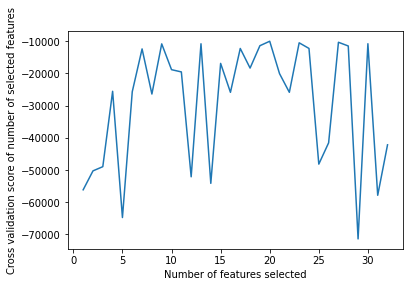

In [38]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [39]:
X_train_rfecv = rfecv.transform(X_train)
X_test_rfecv = rfecv.transform(X_test)

In [40]:
dtr_rfecv_model = model.fit(X_train_rfecv, y_train)

In [41]:

generate_accuracy_and_heatmap(dtr_rfecv_model, X_test_rfecv, y_test)

Accuracy is:  0.9414597999258985
F1 score is:  0.9414597999258985


Actual     10.0     20.0     30.0     49.0     50.0     60.0     70.0     \
Predicted                                                                  
10.0             0        0        0        0        2        0        0   
20.0             0        0        0        2        3        0        2   
30.0             0        0        0        2        5        1        0   
40.0             0        0        0        0        1        0        0   
49.0             0        0        0        2        2        0        0   
50.0             0        2        1        3        6        1        2   
60.0             0        0        0        1        4        0        1   
70.0             0        0        0        0        1        0        0   
79.0             0        0        0        1        1        0        0   
80.0             0        0        0        0        4        1        0   
90.0             0  

1

In [23]:
'''examine percentage of missing values'''
for col in numerical:
    if X_train[col].isnull().mean()>0:
        print(col, X_train[col].isnull().mean())

### Engineering Missing data in categorical variables

In [26]:
for col in categorical:
    if X_train[col].isnull().mean()>0:
        print(col, X_train[col].isnull().mean())

# Outliers

In [27]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

def tree_binariser(var):
    score_ls = [] # mse values stored here

    for tree_depth in [1,2,3,4]:
        # call the model
        tree_model = DecisionTreeRegressor(max_depth=tree_depth)

        # train the model using 3 fold cross validation
        scores = cross_val_score(tree_model, X_train[var].to_frame(), y_train, cv=3, scoring="neg_mean_squared_error")
        score_ls.append(np.mean(scores))

    # find depth with smallest mse
    depth = [1,2,3,4][np.argmin(score_ls)]

    tree_model = DecisionTreeRegressor(max_depth=depth)
    tree_model.fit(X_train[var].to_frame(), X_train.UnitPrice)
    X_train[var] = tree_model.predict(X_train[var].to_frame())
    X_test[var] = tree_model.predict(X_test[var].to_frame())
    # y_test[var] = tree_model.predict(y_test[var].to_frame())

In [28]:
for var in numerical:
    tree_binariser(var)

<ipython-input-27-b6ae5e508fd5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[var] = tree_model.predict(X_train[var].to_frame())
<ipython-input-27-b6ae5e508fd5>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[var] = tree_model.predict(X_test[var].to_frame())
<ipython-input-27-b6ae5e508fd5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [29]:
X_train[numerical].head()

,Frequency,GrossMargin,ItemTimeDiff,MarginDeviation,MarginPerc,PaidAmount,ProductTimeDiff,Quantity,Recency,TotalPrice,UnitCost,UnitPrice
8516,132.047161,133.458975,147.650800,145.835821,145.835821,134.042775,127.319568,152.239787,168.404969,134.042775,134.042775,134.042775
11022,132.047161,133.458975,147.650800,195.027804,195.027804,134.042775,127.319568,129.760870,168.404969,134.042775,134.042775,134.042775
1830,132.047161,133.458975,147.650800,86.693946,86.693946,134.042775,146.276390,152.239787,135.591061,134.042775,134.042775,134.042775
1498,132.047161,133.458975,128.644608,129.271308,129.271308,134.042775,127.319568,152.239787,171.504464,134.042775,134.042775,134.042775
2442,132.047161,133.458975,147.650800,129.271308,129.271308,134.042775,127.319568,152.239787,45.019704,134.042775,134.042775,134.042775


In [30]:
# explore how many unique buckets we have in our engineered variables
for var in numerical:
    print(var, len(X_train[var].unique()))

Frequency 2
GrossMargin 4
ItemTimeDiff 4
MarginDeviation 15
MarginPerc 15
PaidAmount 2
ProductTimeDiff 9
Quantity 9
Recency 12
TotalPrice 2
UnitCost 2
UnitPrice 2


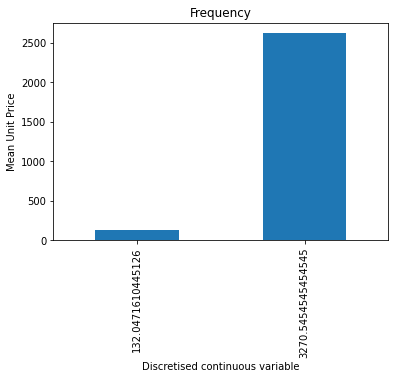

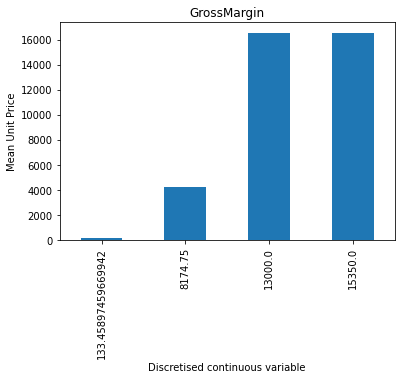

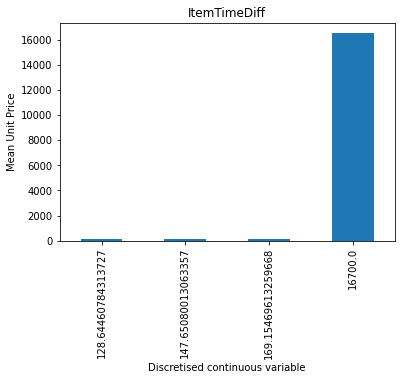

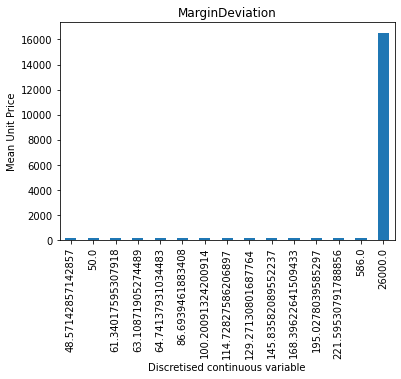

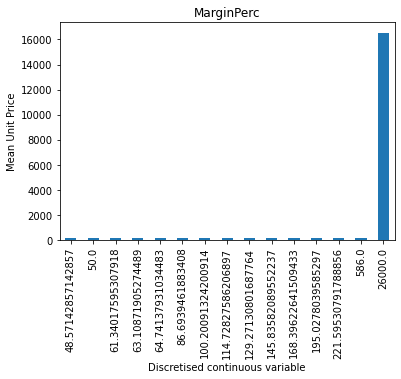

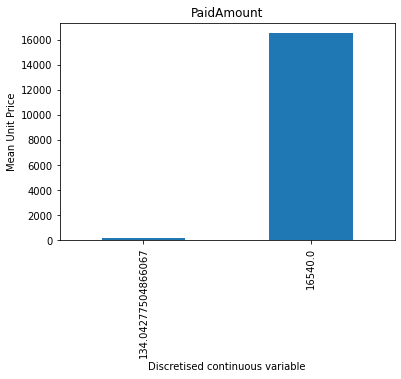

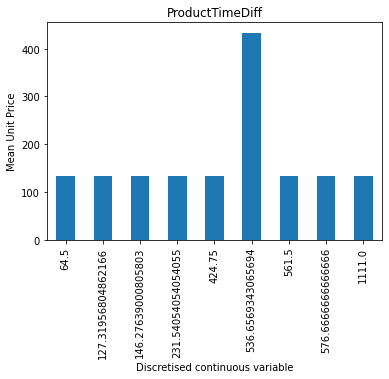

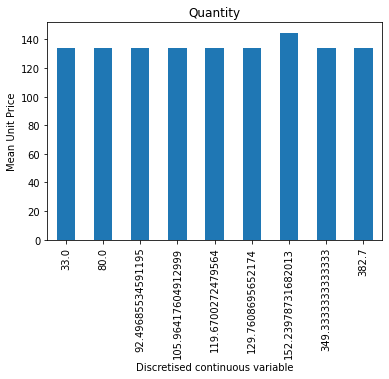

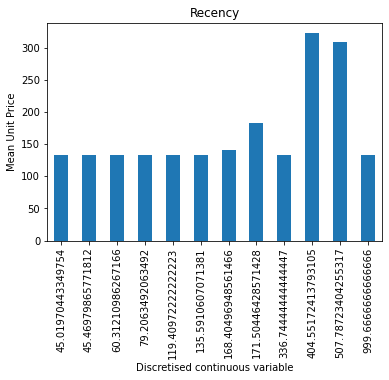

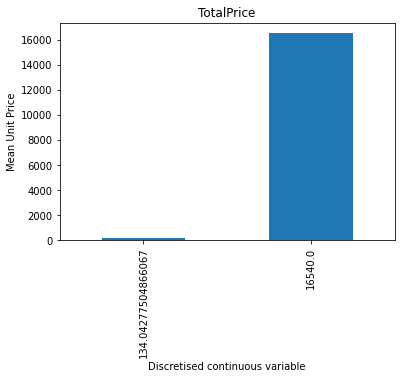

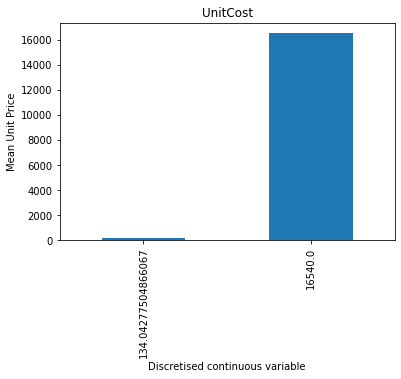

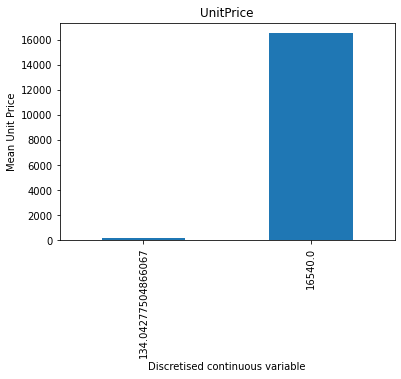

In [45]:
for var in numerical:
    X_train.groupby(var)['UnitPrice'].mean().plot.bar()
    plt.title(var)
    plt.ylabel("Mean Unit Price")
    plt.xlabel("Discretised continuous variable")
    plt.show()

## Engineering rare labels in categorical and discrete variables

In [32]:
def rare_imputations(variable):
    # find frequent labels / discrete numbers
    temp = X_train.groupby([variable])[variable].count()/np.float(len(X_train))
    frequent_cat = [x for x in temp.loc[temp>0.03].index.values]

    X_train[variable] = np.where(X_train[variable].isin(frequent_cat), X_train[variable], 'Rare')
    X_test[variable] = np.where(X_test[variable].isin(frequent_cat), X_test[variable], 'Rare')

In [33]:
# find infrequent labels in the categorical variables and mark them as 'Rare'

for var in categorical:
    rare_imputations(var)

<ipython-input-32-bf162b5b61cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[variable] = np.where(X_train[variable].isin(frequent_cat), X_train[variable], 'Rare')
<ipython-input-32-bf162b5b61cd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[variable] = np.where(X_test[variable].isin(frequent_cat), X_test[variable], 'Rare')
<ipython-input-32-bf162b5b61cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [34]:
# find infrequent labels in the discrete variables and mark them as 'Rare'

for var in discrete:
    rare_imputations(var)

<ipython-input-32-bf162b5b61cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[variable] = np.where(X_train[variable].isin(frequent_cat), X_train[variable], 'Rare')
<ipython-input-32-bf162b5b61cd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[variable] = np.where(X_test[variable].isin(frequent_cat), X_test[variable], 'Rare')
<ipython-input-32-bf162b5b61cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

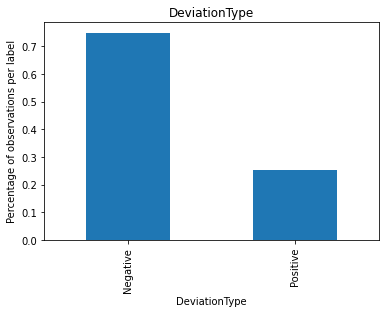

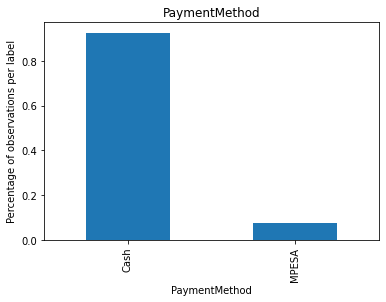

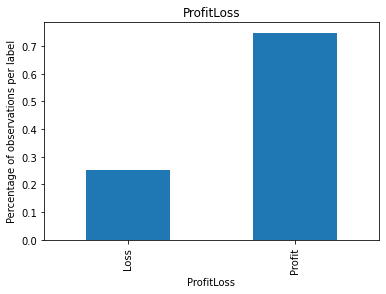

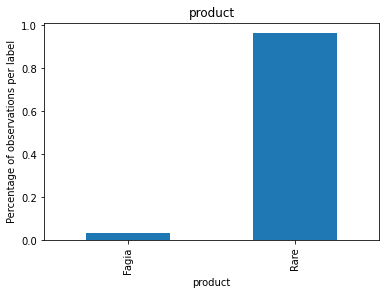

In [35]:
# confirming that our change worked

for var in categorical:
    (X_train.groupby(var)[var].count() / np.float(len(X_train))).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()

## Encoding categorical and discrete variables

In [36]:
def encode_categorical(var, target):
    ordered_labels = X_train.groupby([var])[target].mean().to_dict()

    # encode variables
    X_train[var] = X_train[var].map(ordered_labels)
    X_test[var] = X_test[var].map(ordered_labels)

In [37]:
# encode labels in categorical vars
for var in categorical:
    encode_categorical(var, 'UnitPrice')

<ipython-input-36-06d1aad9e525>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[var] = X_train[var].map(ordered_labels)
<ipython-input-36-06d1aad9e525>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[var] = X_test[var].map(ordered_labels)


In [38]:
# encode labels in discrete vars
for var in discrete:
    encode_categorical(var, 'UnitPrice')

<ipython-input-36-06d1aad9e525>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[var] = X_train[var].map(ordered_labels)
<ipython-input-36-06d1aad9e525>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[var] = X_test[var].map(ordered_labels)


## Feature scaling

In [40]:
# creating a list of training variables

training_vars = [var for var in X_train.columns if var not in ['number', 'UnitPrice']]
print('Total number of training variables: ', len(training_vars))

Total number of training variables:  29


In [41]:
training_vars

['Day',
 'DayOfWeek',
 'DeviationType',
 'Frequency',
 'GrossMargin',
 'Hour',
 'ItemTimeDiff',
 'LastPurDay',
 'LastPurHour',
 'LastPurMinute',
 'LastPurMonth',
 'MarginDeviation',
 'MarginPerc',
 'Minute',
 'Month',
 'PaymentMethod',
 'ProductDiscount',
 'ProductDiscountAmount',
 'ProductTimeDiff',
 'ProfitLoss',
 'Quantity',
 'Recency',
 'TotalPrice',
 'UnitCost',
 'UnitPrice',
 'WeekDayOfLastPur',
 'WeekOfLastPur',
 'WeekOfMonth',
 'product']

In [42]:

''' try out StandardScaler as well '''

# fit scaler
scaler = MinMaxScaler()
scaler.fit(X_train[training_vars])

MinMaxScaler()

In [43]:
MinMaxScaler(copy=True, feature_range=(0,1))

MinMaxScaler()

In [44]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10794 entries, 8516 to 2732
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Day                    10794 non-null  int64  
 1   DayOfWeek              10794 non-null  int64  
 2   DeviationType          10794 non-null  float64
 3   Frequency              10794 non-null  float64
 4   GrossMargin            10794 non-null  float64
 5   Hour                   10794 non-null  int64  
 6   ItemTimeDiff           10794 non-null  float64
 7   LastPurDay             10794 non-null  int64  
 8   LastPurHour            10794 non-null  int64  
 9   LastPurMinute          10794 non-null  int64  
 10  LastPurMonth           10794 non-null  int64  
 11  MarginDeviation        10794 non-null  float64
 12  MarginPerc             10794 non-null  float64
 13  Minute                 10794 non-null  int64  
 14  Month                  10794 non-null  int64  
 15  

# Feature Selection

In [45]:
# X_train.info()
#

In [46]:
# '''using Pearson Correlation'''
# plt.figure(figsize=(15,10))
# cor = X_train.corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()
#

In [47]:
# '''checking for correlation with target columns i.e PaidAmount/TotalPrice and product'''
# cor_target = abs(cor[['product', 'TotalPrice']])
# cor_target
#

In [48]:
# from sklearn.linear_model import LinearRegression
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import  LassoCV
#
# model = LinearRegression()
# rfe = RFE(model, 7) # initializing the model
# X_rfe = rfe.fit_transform(X_train, y_train) # transforming the data using RFE
# model.fit(X_rfe, y_train) # fitting the data to the model
# print(rfe.support_)
# print(rfe.ranking_)
#

In [49]:
# # number of features
# nof_list = np.arange(1,31)
# high_score = 0
#
# #variable to store optimum features
# nof = 0
# score_list = []
# for n in range(len(nof_list)):
#     model = LinearRegression()
#     rfe = RFE(model, nof_list[n])
#     X_train_rfe = rfe.fit_transform(X_train, y_train)
#     X_test_rfe = rfe.transform(X_test)
#     model.fit(X_train_rfe, y_train)
#     score = model.score(X_test_rfe, y_test)
#     score_list.append(score)
#     if score>high_score:
#         high_score = score
#         nof = nof_list[n]
#
# print("Optimum number of features: %d" %nof)
# print("Score with %d features: %f" % (nof, high_score))
#

In [50]:
# cols = list(X_train.columns)
# model = LinearRegression()
# # initialize RFE model
# rfe = RFE(model, 29)
# x_rfe = rfe.fit_transform(X_train, y_train)
# # fit data into the model
# model.fit(x_rfe, y_train)
# temp = pd.Series(rfe.support_, index=cols)
# selected_features_rfe = temp[temp==True].index
# print(selected_features_rfe)
#

## Feature importance using Lasso model

In [51]:
# reg = LassoCV()
# reg.fit(X_train, y_train)
# print("Best alpha using built-in LassoCV: %f" %reg.alpha_)
# print("Best score using built-in LassoCV: %f" %reg.score(X_train, y_train))
# coef = pd.Series(reg.coef_, index=X_train.columns)
#

In [52]:
# print("Lasso picked " + str(sum(coef!=0)) + " variables and eliminated the other " + str(sum(coef == 0)) +" variables")
#

In [53]:
# imp_coef = coef.sort_values()
# import matplotlib
# matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
# imp_coef.plot(kind="barh")
# plt.title("Feature importance using Lasso Model")
